# Step 2: Pre-processing - Resampling 🌐

I want to produce a 250 x 250m grid of probability of presence of Zosteraceae. However, the horizontal resolution of my input datasets are different from 250 x 250m. I have 3 different type of datasets : 
- `filtered_Artportalen-Zosteraceae.csv` is a point dataset
- `filtered_BAL-MYP-ERGOM_BGC-AnnualMeans-2015.nc`, `yearly_mean_CMEMS_BAL_WAV_MY_2015.nc` and `filtered_BAL-MYP-NEMO_PHY-AnnualMeans-2015.nc` are 2km*2km resolution
- `filtered_bathymetry` is 115m*115m resolution
Morover, I need to ensure that all your datasets (point and raster) align perfectly on the same 250m x 250m grid. I need to apply a consistent transformation and resampling process.

For these steps, I used the [Copernicus Marine documentation](https://help.marine.copernicus.eu/en/articles/7924877-how-to-reduce-or-increase-the-spatial-grid-resolution-of-a-dataset-in-python) to help me.

#### 📚 Required Libraries
To carry out this process, I need the following libraries:
- **`rasterio`**: to resample.
- **`numpy`**: to resample.
- **`geopandas`**: For working with geometries.
- **`shapely`**: to work with bounding boxes and create the grid.

- **`netCDF4`**: For working with NetCDF files, the format used by this dataset.

### 🛠️ Steps:
1. **Generate the Grid**: With the Living Lab West geometry, I created a grid with 250m by 250m resolution.
2. **Resampling the Bathymetry Data**: ...
3. **Upsample the 115m x 115m raster to 250m x 250m**: .....
4. **Rasterize the Zosteraceae presence data onto a 250m x 250m grid**: .....


______

## 🛠️ Generating the Grid

With the Living Lab West geometry, I create a grid with 250m by 250m resolution. I used the `geopandas` library to handle this step, as it allows me to work with geometries.

In [3]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Polygon, Point
from shapely.ops import unary_union
from shapely.geometry import box

The geometry of your region is reprojected into a projected CRS `EPSG:32633` to make sure distances are measured in meters, which is essential for grid calculations.

In [4]:
# Load the Living Lab West geometry (this could be the combined geometry of Kattegat and Skagerrak)
livinglab_west = gpd.read_file("livinglab_west.json")

# Reproject the geometry to a projected CRS (e.g., UTM Zone 33N, EPSG:32633)
livinglab_west = livinglab_west.to_crs(epsg=32633)

# Define the grid resolution (250m by 250m)
grid_resolution = 250

# Get the bounds of the Living Lab West region
minx, miny, maxx, maxy = livinglab_west.total_bounds

A regular grid with 250m x 250m cells is created within the bounding box of the region. This grid doesn't respect the shape of the region yet, it’s just a rectangular grid covering the entire bounding box. The `intersection()` method is used to clip the grid to the region’s geometry, ensuring that only the grid cells that overlap the Living Lab West region are kept. The `.unary_union` is used to combine the multiple geometries into one for the intersection operation.

In [5]:
# Create a grid of 250x250m within the bounds of the Living Lab West
grid_cells = []
for x in np.arange(minx, maxx, grid_resolution):
    for y in np.arange(miny, maxy, grid_resolution):
        grid_cells.append(Polygon([(x, y),
                                   (x + grid_resolution, y),
                                   (x + grid_resolution, y + grid_resolution),
                                   (x, y + grid_resolution)]))
        
# Create a GeoDataFrame for the grid with the same CRS as the Living Lab West region
grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs=livinglab_west.crs)

I used Spatial Indexing to Speed Up Clipping. `Geopandas` allows for spatial indexing with rtree (a library for spatial indexing), which can speed up operations like clipping or spatial joins.

In [7]:
# Create a spatial index for the region geometry
from rtree import index

# Create an R-tree spatial index for the Living Lab West geometry
idx = index.Index()

# Add the geometries of the Living Lab West region to the index
for i, geometry in enumerate(livinglab_west.geometry):
    # Only use the exterior of the polygon (ignoring the holes)
    idx.insert(i, geometry.exterior.bounds)

# Filter grid cells that intersect with the region geometry using the index
grid_cells_clipped = []
for cell in grid.geometry:
    # Use the exterior of the grid cell to check for intersections
    if any(livinglab_west.geometry.intersects(cell)):
        grid_cells_clipped.append(cell)


In [ ]:
# Save the clipped grid cells to a GeoDataFrame
clipped_grid = gpd.GeoDataFrame({'geometry': grid_cells_clipped}, crs=livinglab_west.crs)
# Save the clipped grid to a file
clipped_grid.to_file("clipped_grid_32633.geojson", driver='GeoJSON')

To visualize the resulte, I opened the clipped_grid in QGIS as a vector layer.

## 🛠️ Resampling the Bathymetry Data

In [18]:
import geopandas as gpd
from shapely.geometry import Point
import xarray as xr
import rasterstats as rs

Because my dataset is quite large, I need to use GeoTIFF format rather than numpy array

In [16]:
# Load the data
bathymetry_raster = "D5_2024.tif"  # Path to your bathymetry GeoTIFF
raster_crs = "EPSG:4326"  # Coordinate Reference System of the raster
clipped_grid_32633 = gpd.read_file("clipped_grid_32633.geojson")

In [17]:
# Reproject the grid if necessary
clipped_grid_4326 = clipped_grid_32633.to_crs(raster_crs)  # Align with the CRS of the raster

In [20]:
# Perform zonal statistics: calculate the mean of the bathymetry values within each grid cell
zonal_stats = rs.zonal_stats(clipped_grid_4326, bathymetry_raster, stats="mean")

In [21]:
# Convert the zonal stats results to a DataFrame for easier manipulation
zonal_stats_df = pd.DataFrame(zonal_stats)

# Check the first few rows of the zonal stats DataFrame
print(zonal_stats_df.head())

         mean
0 -459.075317
1 -462.190002
2 -466.197754
3 -471.135791
4 -475.315869


In [28]:
# Add the mean bathymetry values to your grid GeoDataFrame
clipped_grid_4326['mean_bathymetry'] = zonal_stats_df['mean']

# Check the updated grid with mean bathymetry values
print(clipped_grid_4326.head())

                                            geometry  mean_bathymetry
0  POLYGON ((10.03035 58.25918, 10.03459 58.25935...      -459.075317
1  POLYGON ((10.03003 58.26142, 10.03428 58.26158...      -462.190002
2  POLYGON ((10.02972 58.26365, 10.03396 58.26382...      -466.197754
3  POLYGON ((10.0294 58.26589, 10.03365 58.26606,...      -471.135791
4  POLYGON ((10.02909 58.26813, 10.03333 58.26829...      -475.315869


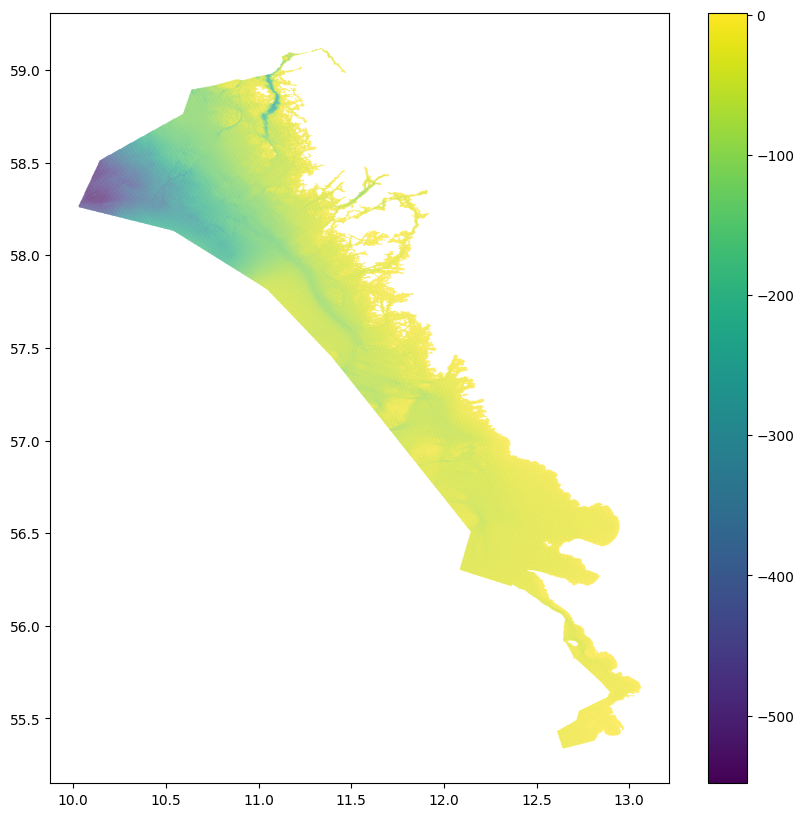

In [29]:
import matplotlib.pyplot as plt

# Plot the grid with the resampled bathymetry values (mean bathymetry per grid cell)
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the grid with the mean bathymetry values
clipped_grid_4326.plot(ax=ax, column='mean_bathymetry', cmap='viridis', legend=True, edgecolor='none', linewidth=0)

# Set aspect ratio to equal to avoid distortion
ax.set_aspect('equal')

# Show the plot
plt.show()

In [37]:
# Extract the centroid coordinates of each cell
clipped_grid_4326['centroid'] = clipped_grid_4326.geometry.centroid
longitude = clipped_grid_4326['centroid'].x.values  # Extract longitude from centroid
latitude = clipped_grid_4326['centroid'].y.values   # Extract latitude from centroid

# Extract the mean bathymetry values
mean_bathymetry_values = clipped_grid_4326['mean_bathymetry'].values

# Create an xarray DataArray with the spatial coordinates and mean bathymetry values
data_array = xr.DataArray(
    mean_bathymetry_values, 
    dims=["grid_cell"],
    coords={"grid_cell": range(len(clipped_grid_4326))},  # Coordinate based on the grid cell index
    name="mean_bathymetry"
)

# Create an xarray Dataset (you can add more variables here if needed)
dataset = xr.Dataset({
    "mean_bathymetry": data_array
})

C:\Users\PC\AppData\Local\Temp\ipykernel_9924\1672228019.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clipped_grid_4326['centroid'] = clipped_grid_4326.geometry.centroid


In [38]:
# Save the dataset to a NetCDF file
output_nc = "grid_variables.nc"
dataset.to_netcdf(output_nc)

In [40]:
ds = xr.open_dataset(output_nc)
ds

<xarray.Dataset> Size: 4MB
Dimensions:          (grid_cell: 240356)
Coordinates:
  * grid_cell        (grid_cell) int64 2MB 0 1 2 3 ... 240353 240354 240355
Data variables:
    mean_bathymetry  (grid_cell) float64 2MB ...

## 🛠️ Resampling the Copernicus Marine datasets

##### 🧪 Baltic Sea Biogeochemistry Reanalysis

In [46]:
import geopandas as gpd
import rasterstats as rs
import numpy as np
from affine import Affine

In [42]:
ds = xr.open_dataset('filtered_BAL-MYP-ERGOM_BGC-AnnualMeans-2019.nc')
ds

<xarray.Dataset> Size: 39MB
Dimensions:  (time: 1, depth: 56, lat: 225, lon: 109)
Coordinates:
  * depth    (depth) float32 224B 0.5016 1.516 2.548 3.602 ... 663.9 688.0 712.0
  * lat      (lat) float32 900B 55.34 55.36 55.37 55.39 ... 59.07 59.09 59.11
  * lon      (lon) float32 436B 10.04 10.07 10.1 10.12 ... 12.99 13.01 13.04
  * time     (time) datetime64[ns] 8B 2019-07-01T06:00:00
Data variables:
    chl      (time, depth, lat, lon) float32 5MB ...
    nh4      (time, depth, lat, lon) float32 5MB ...
    no3      (time, depth, lat, lon) float32 5MB ...
    nppv     (time, depth, lat, lon) float32 5MB ...
    o2       (time, depth, lat, lon) float32 5MB ...
    o2b      (time, lat, lon) float32 98kB ...
    ph       (time, depth, lat, lon) float32 5MB ...
    po4      (time, depth, lat, lon) float32 5MB ...
    spco2    (time, lat, lon) float32 98kB ...
    zsd      (time, lat, lon) float32 98kB ...
Attributes: (12/22)
    CDI:                    Climate Data Interface version 1.9.9rc1 (https://...
    Conventions:            CF-1.0
    history:                Mon Nov 18 19:00:59 2024: cdo cat /net/isilon/ifs...
    source:                 CMEMS BAL MFC NEMO model output converted to NetCDF
    institution:            Baltic MFC, PU Danish Meteorological Institute
    comment:                Data on cropped native product grid. Horizontal v...
    ...                     ...
    westernmost_longitude:  9.041542
    southernmost_latitude:  53.008297
    start_date:             2019-01-01 12:00:00
    NCO:                    netCDF Operators version 4.9.1 (Homepage = http:/...
    CDO:                    Climate Data Operators version 1.9.9rc1 (https://...
    title:                  CMEMS ERGOM annual integrated model fields

In [45]:
# Extract the relevant variable
chl = ds["chl"].values

In [ ]:
# Get the affine transformation of the raster
# Define the transform based on the spatial extent and resolution of your grid
# Here, we assume the grid is uniformly spaced, but you should adjust this for your actual dataset
minx, miny, maxx, maxy = clipped_grid_4326.total_bounds
resolution = 250  # Set your spatial resolution (e.g., 250m for both x and y axes)
transform = Affine(resolution, 0, minx, 0, -resolution, maxy)

# Step 5: Apply zonal_stats using the mean bathymetry and the grid
# Ensure the `mean_bathymetry` variable matches the expected dimensions (rows, cols)
zonal_stats_result = rs.zonal_stats(clipped_grid_4326, chl, stats="mean", affine=transform)

# Step 6: Convert zonal stats result into a pandas DataFrame for easy analysis
zonal_stats_df = pd.DataFrame(zonal_stats_result)

# Step 7: Add the calculated mean bathymetry values to the clipped grid
clipped_grid_4326['mean_bathymetry'] = zonal_stats_df['mean']

# Optional: Check the updated GeoDataFrame with mean bathymetry
print(clipped_grid_4326.head())